In [1]:
using Pkg
Pkg.activate(normpath(joinpath(@__DIR__, "..")))

  Activating environment at `~/FiB/reco_code/NReco/Project.toml`


In [2]:
using ATools
using NReco
using Configurations
using DataFrames
using Glob
using HDF5
using Plots
using Statistics
using StatsBase
using Unitful

import Unitful: ps

In [3]:
## Change the configuration .toml to change the input and cuts.
config_file = "../config/cal_n5_20mm.toml"
conf        = from_toml(NReco.CalConfig, config_file)

NReco.CalConfig("../../h5data/", "n5-window-dz1m-LXe20mm-1-n5/", "plot_dir", 1900.0f0, 2200.0f0, false, NReco.CalFunction("../config/radius_calibration.h5", "n3-20mm", "cstd", 1.69f0))

In [4]:
## Basic setup: Variables shouold be adjusted for each relevant run
# normalisation: number of decays simulated, should be saved somewhere!
# rmin         : Ring minimum r
# rmax         : Ring maximum r
# in_dir       : directory where the output folders of makenema.jl are.
# config       : subdirectory for input/output
# plot_dir     : base directory for plots
in_dir    = conf.input_dir
config    = conf.conf_dir
plot_dir  = conf.plot_dir
if !isdir(plot_dir)
  mkdir(plot_dir)
end
in_path   = joinpath(in_dir, config)
plot_path = joinpath(plot_dir, config)
if !isdir(plot_path)
  mkdir(plot_path)
end

In [5]:
in_path

"../../h5data/n5-window-dz1m-LXe20mm-1-n5/"

In [6]:
norm, rmin, rmax, ndf = read_evtpar(glob("evt*.h5", in_path))
println(norm, " simulated events, ", nrow(ndf), " with two interactions: ", 100 * nrow(ndf) / norm, "%")

1500000 simulated events, 242163 with two interactions: 16.1442%


In [7]:
## Should go in src/?, here for now
function filter_energies(df::DataFrame, qmin::Float32, qmax::Float32)
    interval = ATools.range_bound(qmin, qmax, ATools.OpenBound)
    ndfq     = filter(x -> interval.(x.q1) .& interval.(x.q2), df)
end

filter_energies (generic function with 1 method)

In [8]:
function calibration_function(calibFunc::NReco.CalFunction, rmin::Real, rmax::Real)
    line_pars = h5open(calibFunc.cal_file) do h5cal
        bias   = read_attribute(h5cal[calibFunc.cal_grp], calibFunc.cal_std * "-bias" )
        lconst = read_attribute(h5cal[calibFunc.cal_grp], calibFunc.cal_std * "-const")
        llin   = read_attribute(h5cal[calibFunc.cal_grp], calibFunc.cal_std * "-lin"  )
        return bias, lconst, llin
    end
    
    cal_func = ATools.predict_interaction_radius(ATools.gpol1(line_pars[2:end]),
        rmin, rmax, line_pars[1])
    return cal_func
end

calibration_function (generic function with 1 method)

In [9]:
cal_func = calibration_function(conf.cal_func, rmin, rmax)
ndfq     = filter_energies(ndf, conf.qmin, conf.qmax)
if conf.cal_func.cal_std == "cstd"
  # We want to use the combined std which isn't saved in the H5
  comb_std(z, phi) = sqrt(z^2 + (rmax * phi)^2)
  transform!(ndfq, [:zstd1, :phistd1] => ByRow(comb_std) => :cstd1,
            [:zstd2, :phistd2] => ByRow(comb_std) => :cstd2)
end
sym1 = Symbol(conf.cal_func.cal_std * "1")
sym2 = Symbol(conf.cal_func.cal_std * "2")
transform!(ndfq, sym1 => cal_func => :r1x, sym2 => cal_func => :r2x)

,event_id,phot1,phot2,nsipm1,nsipm2,q1,q2,r1,r2,r1x
,Int64,Bool,Bool,Int64,Int64,Float32,Float32,Float32,Float32,Float64
1,226,0,0,70,70,2141.0,2035.0,362.712,368.836,360.69
2,313,0,1,150,150,2086.0,1983.0,353.526,354.858,353.093
3,517,1,0,126,126,2075.0,1922.0,353.544,363.568,354.608
4,604,1,0,110,110,2063.0,2048.0,356.441,365.407,356.162
5,681,1,1,107,107,2041.0,1968.0,357.178,368.617,357.363
6,700,0,1,77,77,2011.0,2130.0,355.537,362.885,360.315
7,942,0,0,56,56,1932.0,2121.0,366.797,368.144,363.607
8,993,0,0,20,20,1921.0,1949.0,368.998,355.517,368.032
9,1074,1,0,142,142,1984.0,2069.0,353.479,363.173,353.429


# NEMA5

In [10]:
println(names(ndfq))

["event_id", "phot1", "phot2", "nsipm1", "nsipm2", "q1", "q2", "r1", "r2", "r1x", "r2x", "phistd1", "phistd2", "widphi1", "widphi2", "zstd1", "zstd2", "widz1", "widz2", "corrzphi1", "corrzphi2", "xt1", "xt2", "yt1", "yt2", "zt1", "zt2", "t1", "t2", "x1", "x2", "y1", "y2", "z1", "z2", "xr1", "xr2", "yr1", "yr2", "zr1", "zr2", "tr1", "tr2", "xb1", "xb2", "yb1", "yb2", "zb1", "zb2", "ta1", "ta2", "xs", "ux", "ys", "uy", "zs", "uz", "cstd1", "cstd2"]


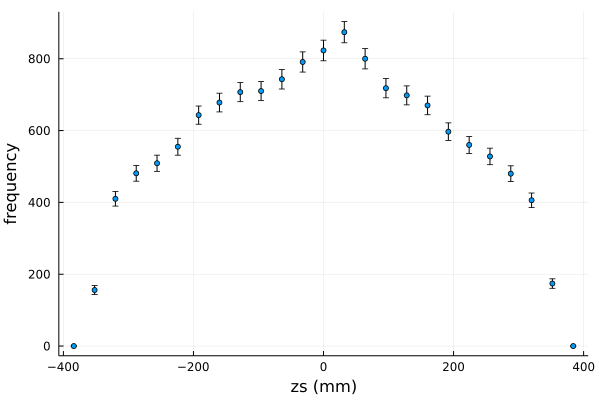

In [11]:
h,p = hist1d(ndfq.zs, "zs (mm)", 25, -400.0f0, 400.0f0, norm=false)
plot(p)

In [12]:
png(p, joinpath(plot_path, "event_distribution"))

In [13]:
revents = sum(h.weights)
println("events recorded in z bins =", h.weights)
println("sensitivity per bin =", h.weights/norm)
println("sensitivity  (%) =", 100 * revents/norm)


events recorded in z bins =[0, 156, 410, 481, 509, 555, 643, 678, 707, 710, 743, 791, 823, 874, 800, 718, 698, 670, 597, 560, 528, 480, 406, 174, 0]
sensitivity per bin =[0.0, 0.000104, 0.00027333333333333333, 0.0003206666666666667, 0.00033933333333333336, 0.00037, 0.00042866666666666666, 0.000452, 0.0004713333333333333, 0.0004733333333333333, 0.0004953333333333333, 0.0005273333333333333, 0.0005486666666666667, 0.0005826666666666667, 0.0005333333333333334, 0.0004786666666666667, 0.00046533333333333333, 0.00044666666666666666, 0.000398, 0.0003733333333333333, 0.000352, 0.00032, 0.00027066666666666667, 0.000116, 0.0]
sensitivity  (%) =0.9140666666666667


In [14]:
hs =  h.weights / norm;
he = 0.001* sqrt.(hs);

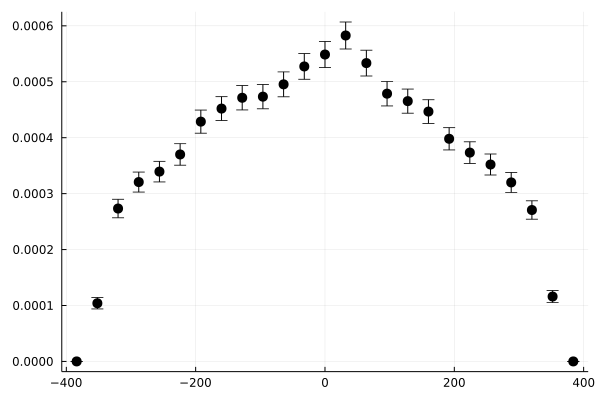

In [15]:
p1 = scatter(centers(h),hs, yerror=he,
	          shape = :circle, markersize=6, color = :black, legend=false, fmt = :png)

In [16]:
png(p1, joinpath(plot_path, "proportion_distribution"))

## normalize to counts per MBq

In [17]:
N = 1e+6 # 1 MBq
hA = hs * N
he = sqrt.(hA);

Counts per 1M decays = 9140.666666666666


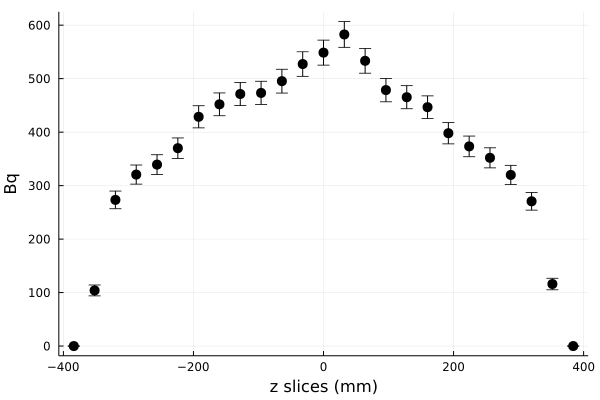

In [18]:
println("Counts per 1M decays = ", sum(hA))
p2 = scatter(centers(h),hA, yerror=he,
	          shape = :circle, markersize=6, color = :black, legend=false, fmt = :png)
xlabel!("z slices (mm)")
ylabel!("Bq")

In [19]:
png(p2, joinpath(plot_path, "MBq_distribution"))

In [20]:
## Save some info about the run to file
h5open("nema5_rates.h5", "cw") do h5out
  grp = create_group(h5out, config)
  attributes(grp)["PerGeneratedEvent"]   = revents / norm
  attributes(grp)["PerMBqActivity_cnts"] = sum(hA)
end

9140.666666666666